In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

In [5]:
label = sorted(["fake","real"])

create array

In [4]:
path = "./TrainingDataSet/"
images_np = tf.keras.utils.image_dataset_from_directory(path,color_mode="grayscale",image_size=(100,100))

Found 1813 files belonging to 2 classes.


Display first batch

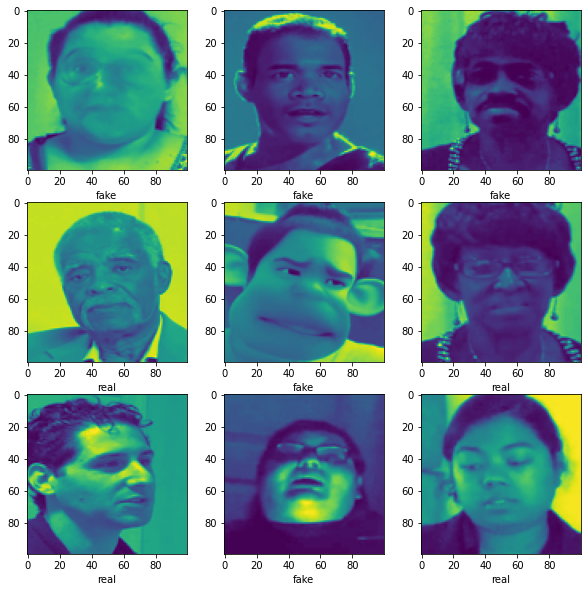

In [6]:
data_iterator = images_np.as_numpy_iterator()
batch = data_iterator.next()

idx = np.random.randint(len(batch[0]) - 9)
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(batch[0][i])
    plt.xlabel(label[batch[1][i]])
plt.show()

Normalize

In [7]:
images_np = images_np.map(lambda x, y: (x/255,y))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Split Data

In [8]:
train_size = int(len(images_np)*0.7)
val_size =  int(len(images_np)*0.2)
test_size = int(len(images_np)*0.1)

train = images_np.take(train_size)
val = images_np.skip(val_size).take(val_size)
test = images_np.skip(test_size).take(test_size)

Build Deep Learning Model

In [9]:
from tensorflow.keras import Sequential, layers

def build_model():
    model = Sequential()
    # 32 output units, 3 filter size
    model.add(layers.Conv2D(16, 3, 1, activation='relu', padding='same', input_shape=(100, 100, 1)))
    model.add(layers.MaxPooling2D())
    # 32 output units, 5 filter size
    model.add(layers.Conv2D(32, 3, 1, activation='relu'))
    model.add(layers.MaxPooling2D())

    model.add(layers.Conv2D(16, 3, 1, activation='relu'))
    model.add(layers.MaxPooling2D())

    model.add(layers.Flatten())

    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer ='adam',
        loss = tf.losses.BinaryCrossentropy(),
        metrics = ['accuracy'])
    return model

# create model
model = build_model()

# see model details
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 22, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 11, 11, 16)       0

In [11]:
tensorboard_callback = tf.keras.callbacks.TensorBoard("logs")

Train

In [12]:
%%time
history = model.fit(train, epochs=20,validation_data=val, callbacks= [tensorboard_callback])
model.save('./models/Deepfake_Detection.keras')

print("\ninitial accuracy: {} | latest accuracy: {}".format(history.history["accuracy"][0], history.history["accuracy"][-1]))
print("initial loss: {} | latest loss: {}".format(history.history["loss"][0], history.history["loss"][-1]))

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
39/39 [==============================] - ETA: 0s - loss: 0.6804 - accuracy: 0.5673WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7ff54b0e3a60> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and 

Plot Performance

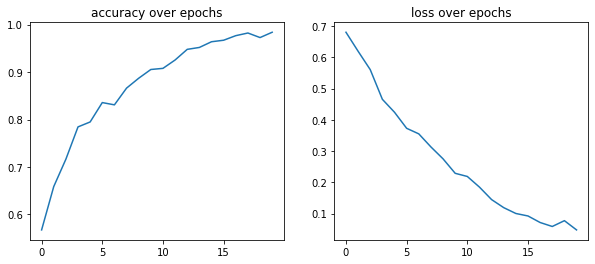

In [13]:
fig, axis = plt.subplots(1, 2, figsize=(10,4))
axis[0].plot(history.history["accuracy"])
axis[0].set_title("accuracy over epochs")
axis[1].plot(history.history["loss"])
axis[1].set_title("loss over epochs")
plt.show()

Evaluate

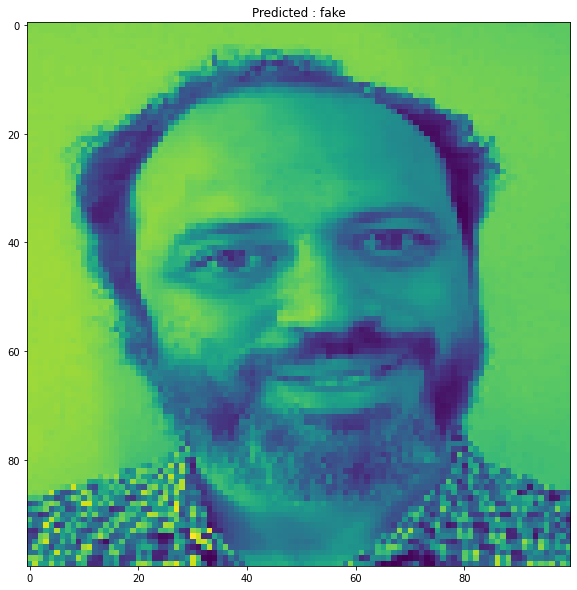

In [16]:
test_path = './test_imgs/fake-test2.png'
image = tf.keras.utils.load_img(test_path,color_mode="grayscale",target_size=(100,100))
input_arr = tf.keras.utils.img_to_array(image)
input_arr = np.array([input_arr])/255.0
predictions = model.predict(input_arr)
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.title("Predicted : "+label[round(predictions[0][0])])
plt.show()